In [1]:
from typing import Optional

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.axes import Axes

In [2]:
df = pd.read_csv('/Users/liibanmohamud/Downloads/Machine Learning/Practice/MLOps/Advanced Multiple Linear Regression/data/Student_Performance.csv')

obj_cols = df.select_dtypes(include='object').columns

# One-hot encode columns of dtype object
for column in obj_cols:
    insert_loc = df.columns.get_loc(column)
    df = pd.concat([df.iloc[:,:insert_loc], pd.get_dummies(df.loc[:, [column]], drop_first=True, dtype=float), df.iloc[:,insert_loc+1:]], axis=1)
    df = df.rename(columns={df.columns[insert_loc] : column})

df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1.0,9,1,91.0
1,4,82,0.0,4,2,65.0
2,8,51,1.0,7,2,45.0
3,5,52,1.0,5,2,36.0
4,7,75,0.0,8,5,66.0


In [3]:
data = (df - df.mean()) / df.std()

In [4]:
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,0.775149,1.704090,1.010404,1.456132,-1.249691,1.862074
1,-0.383461,0.723876,-0.989604,-1.492220,-0.900937,0.508792
2,1.161352,-1.063573,1.010404,0.276791,-0.900937,-0.532194
3,0.002742,-1.005913,1.010404,-0.902549,-0.900937,-1.000637
4,0.775149,0.320259,-0.989604,0.866462,0.145326,0.560842


In [5]:
X = data.drop(columns=['Performance Index'], axis=1).to_numpy()
y = data['Performance Index'].to_numpy()

X = np.column_stack((np.ones(X.shape[0]), X))

X.shape, y.shape, X[:, 0], X[0]

((10000, 6),
 (10000,),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([ 1.        ,  0.77514895,  1.70409044,  1.01040412,  1.45613179,
        -1.24969145]))

In [6]:
def train_test_split(X, y, test_size:float=0.2, val_size:float=0.2, random_state:int=12):

    n = len(X)
    split = int((1-test_size)*n)

    X_non_test, X_test = X[:split], X[split:]
    y_non_test, y_test = y[:split], y[split:]

    np.random.seed(random_state)

    n_non_test = len(X_non_test)

    if val_size != 0:
        split = int((1-val_size)*n_non_test)

        indices = np.random.permutation(n_non_test)
        train_indices = indices[:split]
        val_indices = indices[split:]

        X_train, X_val = X_non_test[train_indices], X_non_test[val_indices]
        y_train, y_val = y_non_test[train_indices], y_non_test[val_indices]

        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_non_test, X_test, y_non_test, y_test


In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(X, y)
X_train.shape, X_val.shape, X_test.shape

((6400, 6), (1600, 6), (2000, 6))

### -------------------------------------- Implementing JAX --------------------------------------

In [8]:
import jax
import jax.numpy as jnp
from jax import jit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [9]:
X_train, X_test, y_train, y_test = map(jnp.array, [
    X_train, X_test, y_train, y_test
])

In [10]:
beta = jnp.zeros(X_train.shape[1])
p=2
jnp.sign(beta).shape, jnp.insert(beta[1:]**(p-1), 0, 0).shape

((6,), (6,))

In [11]:
def compute_mse(y_true, y_pred):
    return jnp.mean((y_pred - y_true)**2)

In [12]:
@jit
def forward_pass(X, beta):
    """  
    Forward pass on data X.

    Args:
        beta (jax.Array): weights and bias.
        X (jax.Array): data
    """
    return jnp.dot(X, beta)

In [13]:
@jit
def grad_loss(beta, X, y, y_pred, 
              p:int=2, # L_p regularization
              lambda_:float=0.01): # Penalty
    """  
    Returns the gradients for the loss wrt. to w and b

    Args:
        beta(jax.Array): weights and bias.
        X_train (jax.Array): training features
        y_train (jax.Array): training targets
    """
    
    e = y_pred - y # Residual
    n = len(y)
    return (2/n) * X.T @ e + lambda_ * p * jnp.sign(beta) * jnp.insert(beta[1:]**(p-1), 0, 0)

In [14]:
def evaluate_on_val_data(beta:jax.Array, X_val:jax.Array, y_val:jax.Array):
    """ 
    Evaluates on validation data.
    """
    y_pred = forward_pass(X_val, beta)

    return compute_mse(y_true=y_val, y_pred=y_pred)

In [15]:
key = jax.random.key(12)
dropout_mask = jax.random.binomial(key, n=1, p=0.8, shape=(10,1), dtype=jnp.float32)
lols = jnp.ones(shape=(10,5))
dropout_mask, dropout_mask * lols

(Array([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]], dtype=float32),
 Array([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.]], dtype=float32))

In [16]:
def training_linear_model(X_train:jax.Array,
                          y_train:jax.Array,
                          X_val:jax.Array,
                          y_val:jax.Array,
                          epochs:int=10000,
                          lr=5e-3,
                          p:int=2,
                          lambda_:float=0.01,
                          max_patience:int=5,
                          dropout:float=0.2,
                          random_state:int=41): 
    """ 
    Performs the training of the linear model from scratch using JAX

    Args:
        X_train (jax.Array): Training features
        y_train (jax.Array): Training labels
        epochs (int): Number of epochs
        learning_rates (float): Learning rates

    Returns:
        beta (jax.Array): optimized weights and bias.
    """
    n = len(X_train)
    
    best_mse = jnp.inf
    patience_counter = 0
    
    beta = jnp.zeros(X_train.shape[1])

    key = jax.random.key(random_state)
    
    for epoch in range(epochs):
        # Dropout
        key, subkey = jax.random.split(key)
        dropout_mask = jax.random.bernoulli(subkey, p=(1-dropout), shape=(n,1))
        X_train_dropout = X_train * dropout_mask

        # Forward pass
        y_pred = forward_pass(X_train_dropout, beta)

        # Calculate loss grads
        dJ_dbeta = grad_loss(beta, X_train_dropout, y_train, y_pred, p, lambda_)

        # Optimiser step
        beta -= lr * dJ_dbeta

        # Validation step
        mse = evaluate_on_val_data(beta=beta, X_val=X_val, y_val=y_val)

        # Potential early stopping
        if mse < best_mse:
            best_mse = mse
            patience_counter = 0
            best_beta = beta
        else:
            patience_counter += 1

        if patience_counter >= max_patience:
            print(f'Stopped at epoch {epoch+1}.')
            break

    y_pred = forward_pass(X_train, beta)

    return best_beta, dJ_dbeta

In [17]:
beta, l = training_linear_model(X_train=X_train,
                             y_train=y_train,
                             X_val=X_val,
                             y_val=y_val,
                             epochs=2000,
                             lr=5e-3,
                             p=2,
                             lambda_= 0,
                             max_patience=200,
                             dropout=0.1,
                             random_state=41)

y_hat = forward_pass(X_test, beta)

mse = compute_mse(y_true=y_test, y_pred=y_hat)

print(f'my mse: {mse}, \nmy mse is better? {mse < 0.011507549}')
beta, data.drop(columns='Performance Index', axis=1).columns

Stopped at epoch 1330.
my mse: 0.011507371440529823, 
my mse is better? True


(Array([-8.7041764e-05,  3.8404137e-01,  9.1835845e-01,  1.6454296e-02,
         4.1350484e-02,  2.8759979e-02], dtype=float32),
 Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
        'Sleep Hours', 'Sample Question Papers Practiced'],
       dtype='object'))

In [18]:
beta, l = training_linear_model(X_train=X_train,
                             y_train=y_train,
                             X_val = X_val, 
                             y_val = y_val,
                             epochs=1000)
beta, beta.shape, l

Stopped at epoch 907.


(Array([-2.0357469e-05,  3.7885845e-01,  9.0652031e-01,  1.6410239e-02,
         4.1038636e-02,  2.8603546e-02], dtype=float32),
 (6,),
 Array([-0.00161028, -0.00212792, -0.00275975, -0.00161131, -0.00209808,
        -0.00183601], dtype=float32))

In [19]:
y_hat = forward_pass(X_test, beta)
y_hat

Array([-1.5675745 , -1.1035466 ,  0.3158344 , ...,  0.91210943,
        2.0087564 ,  0.51527613], dtype=float32)

In [20]:
compute_mse(y_true=y_test, y_pred=y_hat)

Array(0.01174327, dtype=float32)

In [21]:
model = LinearRegression()
fitted_model = model.fit(X_train, y_train)
y_hat_2 = fitted_model.predict(X_test)

In [22]:
compute_mse(y_true=y_test, y_pred=y_hat_2)

Array(0.01150755, dtype=float32)

In [23]:
def denormalize_prediction(y_pred, original_df:pd.DataFrame=df, categories:str='Performance Index'):
    """ 
    Denormalizes normalized predictions.
    """
    mean = original_df[categories].mean()
    std = original_df[categories].std()
    y_pred_unnormalized = y_pred * std + mean
    return y_pred_unnormalized

In [24]:
y_hat_unnorm = denormalize_prediction(y_hat)
y_hat_2_unnorm = denormalize_prediction(y_hat_2)

In [25]:
y_hat_unnorm, y_hat_2_unnorm

(Array([25.107683, 34.022846, 61.292786, ..., 72.74876 , 93.818146,
        65.12457 ], dtype=float32),
 array([24.722017, 33.739956, 61.360523, ..., 72.9703  , 94.32794 ,
        65.2576  ], dtype=float32))

In [26]:
y_test_unnnorm = denormalize_prediction(y_test)

In [27]:
compute_mse(y_hat_unnorm, y_test_unnnorm)

Array(4.3347034, dtype=float32)

In [28]:
compute_mse(y_hat_2_unnorm, y_test_unnnorm)

Array(4.2476935, dtype=float32)

# DIAGNOSTICS

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

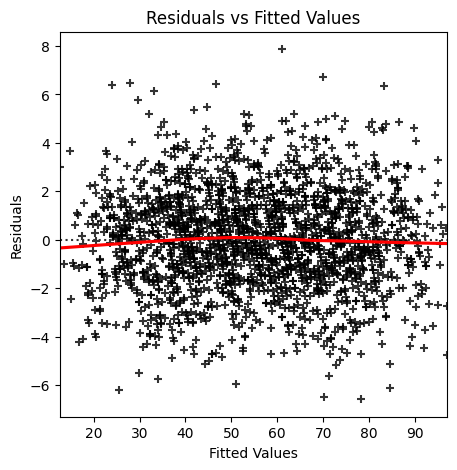

In [30]:
# RESIDUALS AGAINST FITTED VALUES
residuals = y_test_unnnorm - y_hat_unnorm

plt.figure(figsize=(5,5), facecolor='none')
plt.title('Residuals vs Fitted Values')
sns.residplot(x=y_hat_unnorm, y=residuals, lowess=True, scatter_kws={'marker': '+', 'color': 'black'} ,line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

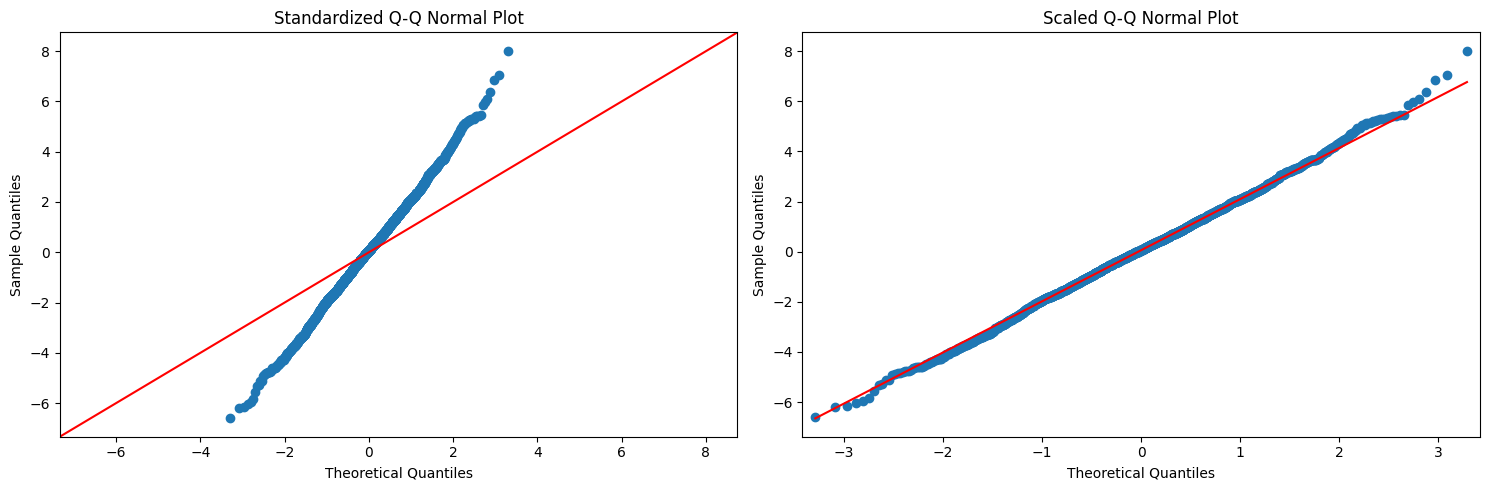

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), facecolor='none')
# Subplot 1
ax1.set_title('Standardized Q-Q Normal Plot')
sm.qqplot(residuals, line='45', ax=ax1)
# Subplot 2
ax2.set_title('Scaled Q-Q Normal Plot')
sm.qqplot(residuals, line='q', ax=ax2)
# Plot
plt.tight_layout()
plt.show()

In [32]:
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

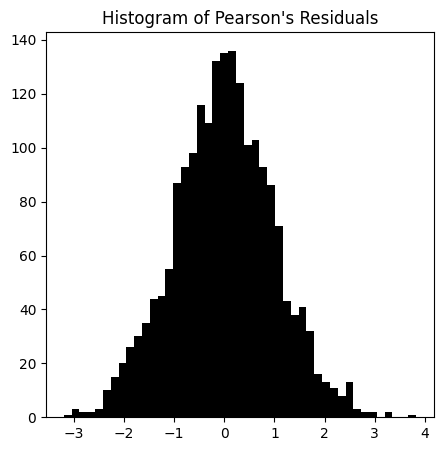

In [33]:
plt.figure(figsize=(5,5), facecolor='none')
plt.title('Histogram of Pearson\'s Residuals')
plt.hist(standardized_residuals, bins=45, color='black')
plt.show()

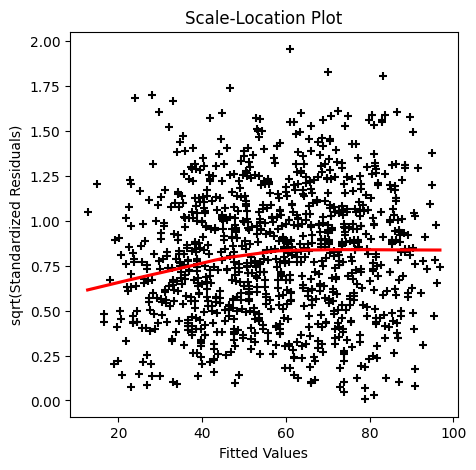

In [34]:
# SCALE-LOCATION PLOT
plt.figure(figsize=(5,5), facecolor='none')
plt.title('Scale-Location Plot')
plt.scatter(y_hat_unnorm, jnp.sqrt(standardized_residuals), marker='+', color='black')
sns.regplot(x=y_hat_unnorm, y=jnp.sqrt(standardized_residuals), lowess=True, scatter=False, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('sqrt(Standardized Residuals)')
plt.show()

In [35]:
@jit
def hat_matrix(X:jax.Array):
    return X @ jnp.linalg.inv(X.T @ X) @ X.T

In [36]:
P = hat_matrix(X_test)

In [37]:
P.shape, P[1,1]

((2000, 2000), Array(0.0029304, dtype=float32))

In [38]:
leverages = jnp.array([P[i,i] for i in range(P.shape[0])])
leverages.shape, residuals.shape

((2000,), (2000,))

In [39]:
r = X_test.shape[1]
levels = [0.5, 1, 2]
colours = ['orange', 'red', 'purple']

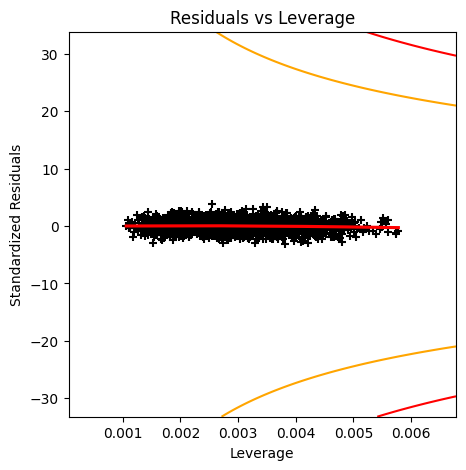

In [40]:
plt.figure(figsize=(5,5), facecolor='none')

plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')

plt.scatter(leverages, standardized_residuals, color='black', marker='+')

standardized_residuals_grid, leverages_grid = jnp.meshgrid(
    jnp.linspace(standardized_residuals.min()-30, standardized_residuals.max()+30, 100),
    jnp.linspace(leverages.min()-1e-3, leverages.max()+1e-3, 100)
)

sns.regplot(x=leverages, 
            y=standardized_residuals, 
            scatter=False,
            line_kws={'color': 'red'},
            lowess=True)

cooks_dist_grid = (standardized_residuals_grid**2)/r * leverages_grid/(1-leverages_grid)

plt.contour(leverages_grid, standardized_residuals_grid, cooks_dist_grid, levels=levels, colors=colours)

plt.show()

In [41]:
class Diagnostics():
        """
        Produces diagnostic plots for the model
        """
        def __init__(self,
                     X: jax.Array,
                     y_true: jax.Array,
                     y_pred: jax.Array):
            self.X = X
            self.y_true = y_true
            self.y_pred = y_pred
            self.residuals = y_true - y_pred
            self.standardized_residuals = (self.residuals - self.residuals.mean())/self.residuals.std() 
            
        def residual_vs_fitted_plot(self,
                                    ax:Axes=None, 
                                    marker:str='+', 
                                    scatter_colour:str='black',
                                    line_colour:str='red'):
            """ 
            Outputs graph of residuals against fitted values.
            """
            if ax is None:
                fig, ax = plt.subplots(figsize=(5,5), facecolor='none')
                
            ax.set_title('Residuals vs Fitted Values')
            sns.residplot(x=self.y_pred, 
                          y=self.residuals, 
                          lowess=True, 
                          scatter_kws={'marker': marker, 'color': scatter_colour},
                          line_kws={'color': line_colour},
                          ax=ax)
            plt.xlabel('Fitted Values')
            plt.ylabel('Residuals')


        def qqplot(self, ax:Axes=None):
            """
            Outputs the graph of the Q-Q plot of the residuals
            """
            if ax is None:
                fig, ax = plt.subplots(figsize=(5,5), facecolor='none')

            ax.set_title('Q-Q Plot of Residuals')
            sm.qqplot(self.residuals, line='q', ax=ax)
            plt.tight_layout()


        def standardized_residuals_histogram(self,
                                             ax:Axes=None,
                                             bins:int=45):
            """
            Outputs histogram of standardized residuals
            """
            if ax is None:
                fig, ax = plt.subplots(figsize=(5,5), facecolor='none')

            plt.figure(figsize=(5,5), facecolor='none')
            ax.set_title('Histogram of Standardized Residuals')
            ax.hist(self.standardized_residuals, bins=bins)


        def scale_location_plot(self, 
                                ax:Axes=None,
                                marker:str='+', 
                                scatter_colour:str='black',
                                line_colour:str='red'):
            """
            Outputs graph of Scale-Location Plot
            """
            if ax is None:
                fig, ax = plt.subplots(figsize=(5,5), facecolor='none')

            # SCALE-LOCATION PLOT
            ax.set_title('Scale-Location Plot')
            ax.scatter(self.y_pred, jnp.sqrt(self.standardized_residuals), marker=marker, color=scatter_colour)
            sns.regplot(x=self.y_pred, 
                        y=jnp.sqrt(self.standardized_residuals), 
                        lowess=True, 
                        scatter=False, 
                        color=line_colour,
                        ax=ax)
            plt.xlabel('Fitted Values')
            plt.ylabel('sqrt(Standardized Residuals)')


        def __hat_matrix(self, X:jax.Array):
            """
            Returns hat matrix for X
            """
            return X @ jnp.linalg.inv(X.T @ X) @ X.T
        
        def residuals_vs_leverage_plot(self,
                                       ax:Axes=None,
                                       levels:list=[0.5,1,2],
                                       colours:list=['orange', 'red', 'purple'],):
            """
            Outputs plot of residuals against leverage.
            """
            # ----- DEFINING ----- #
        
            P = self.__hat_matrix(self.X)
            r = self.X.shape[1] 

            leverages = jnp.array([P[i,i] for i in range(P.shape[0])])

            # ----- PLOTTING ----- #

            if ax is None:
                fig, ax = plt.subplots(figsize=(5,5), facecolor='none')

            ax.set_title('Residuals vs Leverage')
            ax.set_xlabel('Leverage')
            ax.set_ylabel('Standardized Residuals')

            ax.scatter(leverages, self.standardized_residuals, color='black', marker='+')

            standardized_residuals_grid, leverages_grid = jnp.meshgrid(
                jnp.linspace(self.standardized_residuals.min()-30, self.standardized_residuals.max()+30, 100),
                jnp.linspace(leverages.min()-1e-3, leverages.max()+1e-3, 100)
            )

            sns.regplot(x=leverages, 
                        y=self.standardized_residuals, 
                        scatter=False,
                        line_kws={'color': 'red'},
                        lowess=True,
                        ax=ax)

            cooks_dist_grid = (standardized_residuals_grid**2)/r * leverages_grid/(1-leverages_grid)

            ax.contour(leverages_grid, standardized_residuals_grid, cooks_dist_grid, levels=levels, colors=colours, alpha=0.25)
                

        def diagnostic_plots(self,
                             figsize:tuple=(12,12)):
            """ 
            Outputs a 2x2 grid of the diagnostic plots
            """
            fig, axs = plt.subplots(2, 2, figsize=figsize, facecolor='none')

            plt.sca(axs[0,0])
            self.residual_vs_fitted_plot(axs[0,0])
            plt.sca(axs[0,1])
            self.qqplot(axs[0,1])
            plt.sca(axs[1,0])
            self.scale_location_plot(axs[1,0])
            plt.sca(axs[1,1])
            self.residuals_vs_leverage_plot(axs[1,1])

            fig.subplots_adjust(hspace=0.2, wspace=0.2)

            plt.tight_layout()
            plt.show()
            

In [42]:
diag = Diagnostics(X=X_test,
                   y_true=y_test_unnnorm,
                   y_pred=y_hat_unnorm)

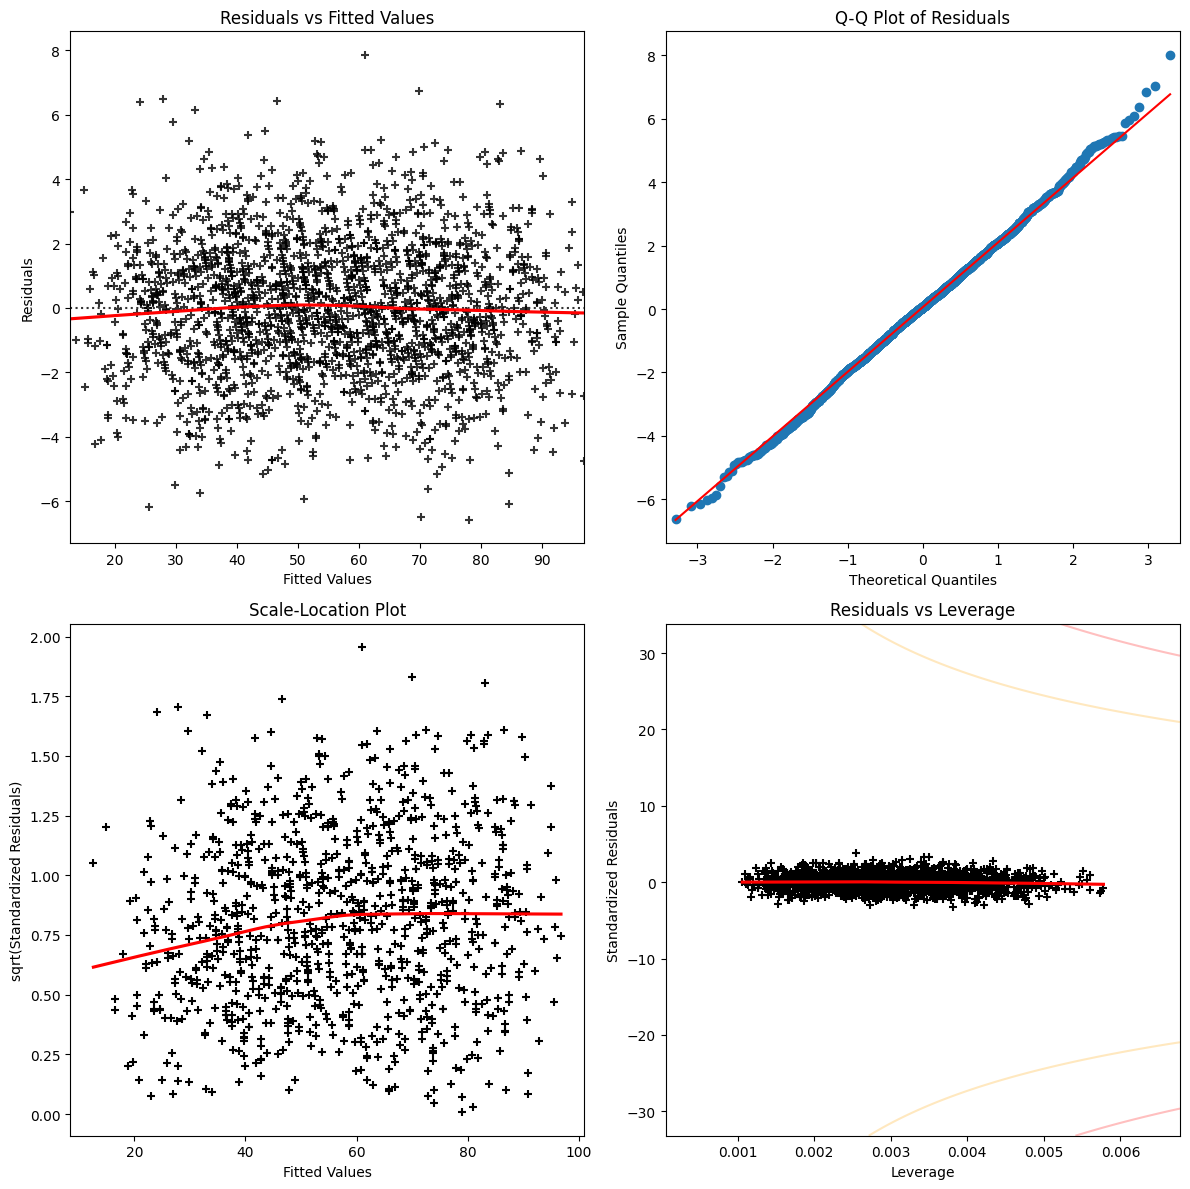

In [43]:
diag.diagnostic_plots()

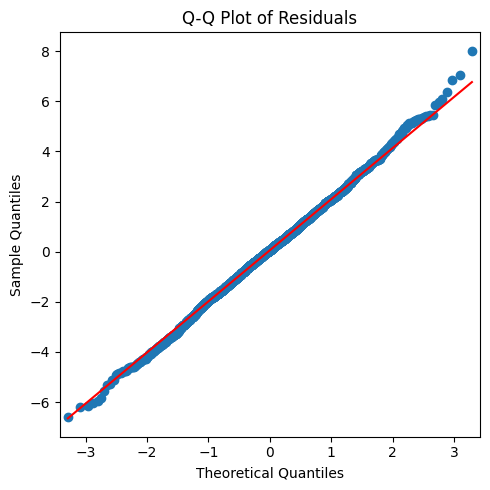

In [44]:
diag.qqplot()

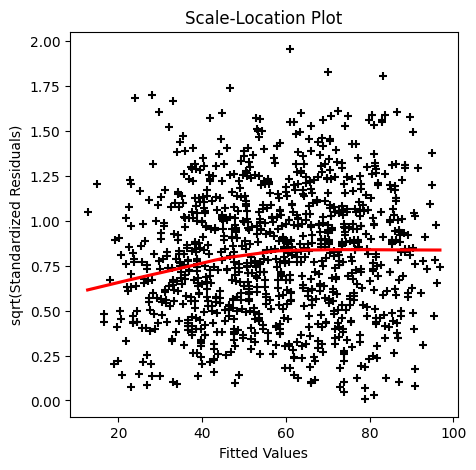

In [45]:
diag.scale_location_plot()

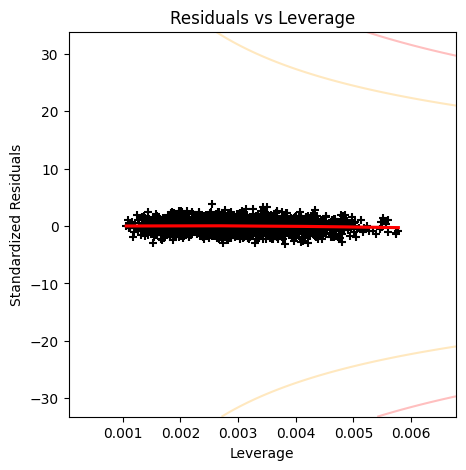

In [46]:
diag.residuals_vs_leverage_plot()

### ------------------------------------------------------------------------------------------------------------------------ #

In [47]:
class Metrics():
    """
    Evaluates using multiple different evaluation methods.
    """
    def __init__(self,
                 y_true: jax.Array,
                 y_pred: jax.Array):
        """
        Args:
            y_true (jax.Array): true labels.
            y_pred (jax.Array): predicted labels.
        """
        self.y_true = y_true
        self.y_pred = y_pred

    def mse(self):
        return compute_mse(y_true=self.y_true,
                                  y_pred=self.y_pred)
    
    def r2_score(self):
        return r2_score(y_true=self.y_true,
                        y_pred=self.y_pred)
    

In [48]:
metric = Metrics(y_true=y_test_unnnorm,
                 y_pred=y_hat_unnorm)

In [49]:
mse = metric.mse()
isinstance(mse, jax.Array)

True

In [50]:
r2 = metric.r2_score()
r2

0.9881302714347839

In [51]:
@jit
def calculate_loss_gradients(beta:jax.Array,
                             X:jax.Array,
                             y:jax.Array,
                             p:int=2,
                             lambda_:float=0.01):
    """  
    Forward pass on data X.

    Args:
        beta (jax.Array): weights and bias.
        X (jax.Array): data
    """
    return (2/len(y)) * X.T @ (jnp.dot(X, beta) - y) + lambda_ * p * jnp.sign(beta) * jnp.insert(beta[1:]**(p-1), 0, 0)

In [52]:
class LinearRegressionModel():
    """
    Class of linear regression models.
    """
    def __init__(self,
                 weights_init:str='zero',
                 epochs:jax.Array=int(1e+5),
                 learning_rate:float=5e-3,
                 p:int=2,
                 lambda_:float=0.,
                 max_patience:int=200,
                 dropout:float=0.2,
                 random_state:int=41):

        self.weights = weights_init
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.p = p
        self.lambda_ = lambda_
        self.max_patience = max_patience
        self.dropout = dropout
        self.random_state = random_state
        self.losses_in_training_data = np.zeros(epochs)
        self.losses_in_validation_data = np.zeros(epochs)
        self.stopped_at = epochs # Records epoch stopped at. First assumes training using every epoch.

    def fit(self, X_train:jax.Array, y_train:jax.Array, X_val:Optional[jax.Array]=None, y_val:Optional[jax.Array]=None):
        """
        Fits model to data inputted.

        Args:
            X_train (jax.Array): training data of features.
            y_train (jax.Array): training data of labels.
            X_val (jax.Array): validation data of features.
            y_val (jax.Array): validation data of labels.
        """

        # Initializing parameters
        best_beta:Optional[jax.Array] = None

        n = len(X_train)

        best_mse = jnp.inf
        
        patience_counter = 0

        key = jax.random.key(self.random_state)

        # Defining the weights initializers
        weights_init_dict = {
            'zero': jnp.zeros(X_train.shape[1]),
            'random': jax.random.normal(key, shape=(X_train.shape[1],)),
            'lecun': jax.random.normal(key, shape=(X_train.shape[1],)) * jnp.sqrt(1/X_train.shape[0]),
            'xavier': jax.random.normal(key, shape=(X_train.shape[1],)) * jnp.sqrt(2/(X_train.shape[0]+y_train.shape[0])),
            'he': jax.random.normal(key, shape=(X_train.shape[1],)) * jnp.sqrt(2/X_train.shape[0])
        }

        self.weights = weights_init_dict[self.weights]

        # Training Loop
        for epoch in range(self.epochs):
            # Dropout
            key, subkey = jax.random.split(key)
            dropout_mask = jax.random.bernoulli(subkey, p=(1-self.dropout), shape=(n,1))
            X_train_dropout = X_train * dropout_mask

            # Calculating loss on training data
            self.losses_in_training_data[epoch] = compute_mse(y_pred=jnp.dot(X_train_dropout, self.weights), y_true=y_train)

            # Calculate loss gradients
            loss_gradient_wrt_beta = calculate_loss_gradients(self.weights, X_train_dropout, y_train, self.p, self.lambda_)

            # Optimiser step
            self.weights -= self.learning_rate * loss_gradient_wrt_beta

            if X_val is not None and y_val is not None:
                # Validation step
                mse = evaluate_on_val_data(beta=self.weights, X_val=X_val, y_val=y_val)
                self.losses_in_validation_data[epoch] = mse

                # Potential early stopping
                if mse < best_mse:
                    best_mse = mse
                    patience_counter = 0
                    best_beta = self.weights
                else:
                    patience_counter += 1

                if patience_counter >= self.max_patience:
                    print(f'Stopped at epoch {epoch+1}.')
                    self.stopped_at = epoch+1
                    break

        self.weights = best_beta

        return self.losses_in_training_data

    def predict(self, X_test:jax.Array):
        """
        Predicts on test data.
        """
        return forward_pass(X_test, self.weights)
    
    def plot_losses(self):
        """ 
        Plot losses.
        """
        plt.figure(figsize=(10,5))
        # Plotting training losses
        plt.title('MSE vs Epochs')
        plt.plot(range(self.stopped_at), self.losses_in_training_data[:self.stopped_at], c='blue', label='Training')
        # Plotting validation losses
        plt.plot(range(self.stopped_at), self.losses_in_validation_data[:self.stopped_at], c='orange', label='Valdation')
        plt.legend()
        plt.show()

Stopped at epoch 1663.


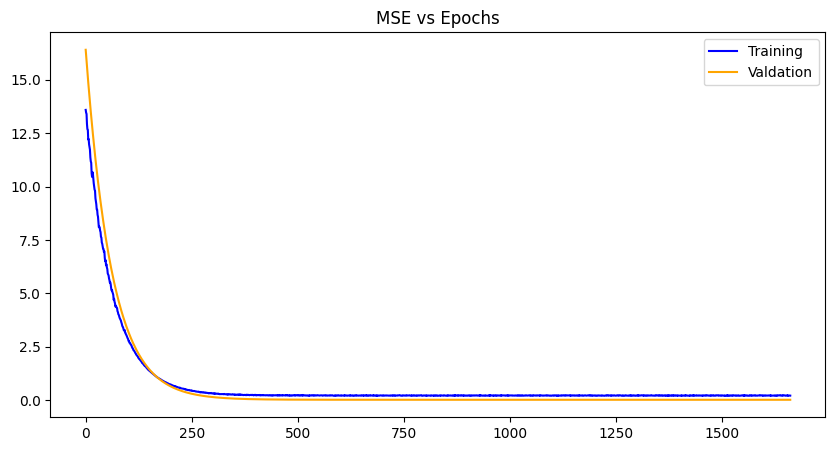

In [67]:
model = LinearRegressionModel(weights_init='random')
loss1 = model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
y_pred = model.predict(X_test)
model.plot_losses()

Stopped at epoch 1663.


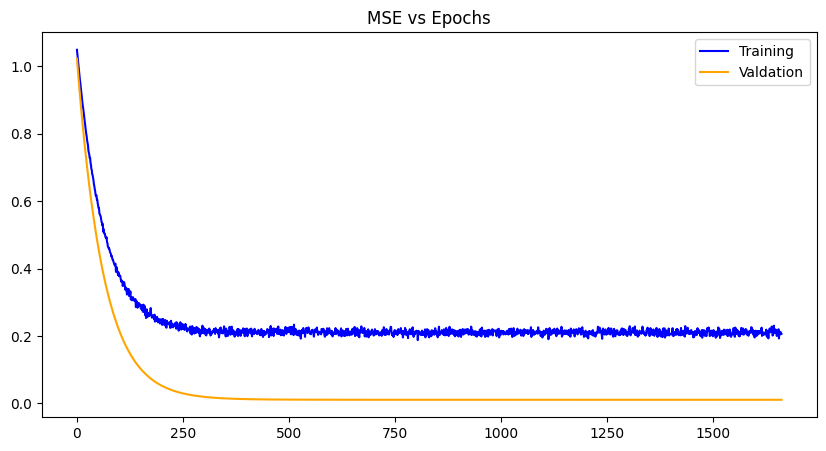

In [64]:
model = LinearRegressionModel(weights_init='lecun')
loss2 = model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
y_pred = model.predict(X_test)
model.plot_losses()

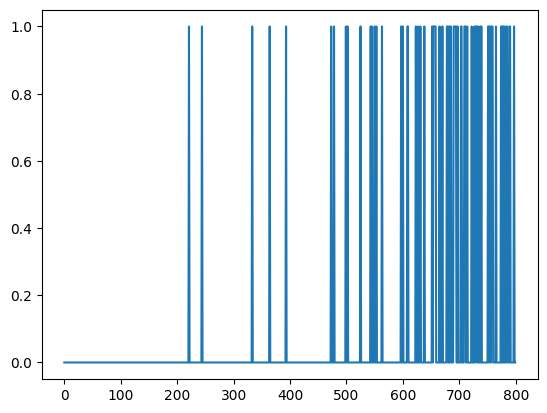

In [55]:
plt.plot(jnp.arange(len(loss1[800:1600])), loss1[800:1600] == loss2[800:1600])

In [56]:
beta_hat = jnp.linalg.inv(X_test.T @ X_test) @ X_test.T @ y_test
beta_hat.shape

(6,)

In [57]:
best_y_hat = jnp.dot(X_test, beta_hat)

In [58]:
compute_mse(y_true=y_test, y_pred=y_pred)

Array(0.01150712, dtype=float32)

In [59]:
best_y_hat.shape 

(2000,)

In [60]:
compute_mse(y_true=y_test, y_pred=best_y_hat)

Array(0.01147058, dtype=float32)